In [1]:
import os
import sys
import pickle
import random
from pathlib import Path
from IPython.display import display


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold, GroupKFold
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import catboost as cab


sys.path.append("../../../")
from kagglib.tabular import (
    AbstractBaseBlock,
    IdentityBlock,
    WrapperBlock,
    LabelEncodingBlock,
    CountEncodingBlock,
    AggBlock,
    run_blocks,
)


pd.set_option('display.max_columns', 300)

# autoreload
%load_ext autoreload
%autoreload 2

In [57]:
class Config:
    exp = "exp043"

    input_path = Path("../input")
    output_path = Path("../output")

    exp_path = output_path / exp
    exp_model_path = exp_path / "model"
    exp_pred_path = exp_path / "pred"

    for _path in [exp_path, exp_model_path, exp_pred_path]:
        if not _path.exists():
            _path.mkdir(parents=True)

    seed = 42
    n_splits = 5

    # catboost
    model_params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "task_type": "CPU",
        "learning_rate": 0.1,
        "iterations": 999999,
        "random_seed": seed,
        "early_stopping_rounds": 100,
        "use_best_model": True,
        "verbose": 1000,
    }

cfg = Config

In [3]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [4]:
anime_df = pd.read_csv(cfg.input_path / "anime.csv")
train_df = pd.read_csv(cfg.input_path / "train.csv")
test_df = pd.read_csv(cfg.input_path / "test.csv")
sample_submission_df = pd.read_csv(cfg.input_path / "sample_submission.csv")

In [5]:
anime_df

,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch
0,000ba7f7e34e107e7544,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",宇宙兄弟,TV,99,"Apr 1, 2012 to Mar 22, 2014","Aniplex, Dentsu, YTV, Trinity Sound",Sentai Filmworks,A-1 Pictures,Manga,24 min. per ep.,PG-13 - Teens 13 or older,150428,16552,37234,13009,6948,76685
1,00427279d72064e7fb69,"Adventure, Slice of Life, Mystery, Historical,...",蟲師,TV,26,"Oct 23, 2005 to Jun 19, 2006","Avex Entertainment, Marvelous, SKY Perfect Wel...",Funimation,Artland,Manga,25 min. per ep.,PG-13 - Teens 13 or older,620736,55482,235371,42786,20017,267080
2,00444b67aaabdf740a68,"Adventure, Slice of Life, Mystery, Historical,...",蟲師 続章,TV,10,"Apr 5, 2014 to Jun 21, 2014","Aniplex, Kodansha, Delfi Sound",Aniplex of America,Artland,Manga,24 min. per ep.,PG-13 - Teens 13 or older,226522,12585,113559,6095,2606,91677
3,00839a3507ab168abe75,"Comedy, Ecchi, Fantasy, School",星刻の竜騎士,TV,12,"Apr 5, 2014 to Jun 21, 2014","Media Factory, AT-X, Sony Music Communications...",Funimation,C-Station,Light novel,24 min. per ep.,R+ - Mild Nudity,170220,8723,118202,3753,8034,31508
4,0192331235e110fe4f76,"Comedy, Harem, Romance, Sci-Fi, Shounen, Space",天地無用！,TV,26,"Apr 2, 1995 to Sep 24, 1995","TV Tokyo, Pioneer LDC","Funimation, Geneon Entertainment USA",AIC,Original,23 min. per ep.,PG-13 - Teens 13 or older,62599,2565,39890,2093,1986,16065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,ff73475b68001c5e533d,"Adventure, Romance, Mecha, Military, Sci-Fi, H...",BLUE GENDER,TV,26,"Oct 8, 1999 to Mar 31, 2000","Youmex, Toshiba EMI",Funimation,AIC,Original,23 min. per ep.,R+ - Mild Nudity,65360,2738,31583,2534,3195,25310
1996,ff8611bae4e43862381f,"Ecchi, Romance, School",フォトカノ,TV,13,"Apr 5, 2013 to Jun 28, 2013","TBS, Enterbrain, BS-TBS, RAY",Sentai Filmworks,Madhouse,Visual novel,23 min. per ep.,PG-13 - Teens 13 or older,93558,6242,45399,3415,8680,29822
1997,ffa143ffd4abec9d2707,"Action, Fantasy, Military, Sci-Fi",GOD EATER,TV,13,"Jul 12, 2015 to Mar 26, 2016","Bandai Visual, Lantis, Anime Consortium Japan",Aniplex of America,ufotable,Game,23 min. per ep.,R - 17+ (violence & profanity),426616,35000,242285,16731,31573,101027
1998,ffb4819df40db39facfa,"Action, Adventure, Fantasy, School, Sci-Fi",鋼殻のレギオス,TV,24,"Jan 11, 2009 to Jun 21, 2009",AMG MUSIC,Funimation,Zexcs,Light novel,24 min. per ep.,R - 17+ (violence & profanity),178908,9139,118689,5611,6544,38925


In [6]:
train_df

,user_id,anime_id,score
0,0008e10fb39e55447333,0669cc0219d468761195,2
1,0008e10fb39e55447333,111adb8835b8a1a2cf54,10
2,0008e10fb39e55447333,1fc8683c393432a2f9c7,1
3,0008e10fb39e55447333,2290175205d55e81b197,8
4,0008e10fb39e55447333,28f173b60331d5cabb0d,9
...,...,...,...
136396,ffa6ff8006f8630f3d11,e9ba5ca32ea7e22e0a55,6
136397,ffa6ff8006f8630f3d11,ea2be994d7e36d2a720a,7
136398,ffa6ff8006f8630f3d11,ee3804a55e2b4ad58aad,7
136399,ffa6ff8006f8630f3d11,fc143f3fa9979ab1c230,9


In [7]:
dup_user_id = set(train_df["user_id"]) & set(test_df["user_id"])
dup_anime_id = set(train_df["anime_id"]) & set(test_df["anime_id"])
train_df["is_seen"] = 0
test_df["is_seen"] = 0

# seen
skf = StratifiedKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
seen_train_idx = (train_df["user_id"].isin(dup_user_id)) & (train_df["anime_id"].isin(dup_anime_id))
seen_test_idx = (test_df["user_id"].isin(dup_user_id)) & (test_df["anime_id"].isin(dup_anime_id))
train_df.loc[seen_train_idx, "is_seen"] = 1
test_df.loc[seen_test_idx, "is_seen"] = 1

seen_train_df = train_df[train_df["is_seen"] == 1].copy().reset_index(drop=True)
seen_train_df["seen_fold"] = -1
for i_fold, (_, valid_idx) in enumerate(skf.split(seen_train_df, seen_train_df["score"])):
    seen_train_df.loc[valid_idx, "seen_fold"] = i_fold


# unseen
sgkf = StratifiedGroupKFold(n_splits=cfg.n_splits, shuffle=True, random_state=cfg.seed)
unseen_train_idx = (~train_df["user_id"].isin(dup_user_id)) | (~train_df["anime_id"].isin(dup_anime_id))
unseen_test_idx = (~test_df["user_id"].isin(dup_user_id)) | (~test_df["anime_id"].isin(dup_anime_id))
train_df.loc[unseen_train_idx, "is_seen"] = 0
test_df.loc[unseen_test_idx, "is_seen"] = 0

train_df["unseen_fold"] = -1
for i_fold, (_, valid_idx) in enumerate(sgkf.split(train_df, train_df["score"], train_df["user_id"])):
    train_df.loc[valid_idx, "unseen_fold"] = i_fold



train_df = pd.merge(train_df, seen_train_df[["user_id", "anime_id", "seen_fold"]], on=["user_id", "anime_id"], how="left")

# Preprocess

In [8]:
# 文字列で表された月を数値に変換
month_dict = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
    'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
    'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

In [9]:
def convert_to_minutes(time_str):
    time_str = time_str.lower()
    
    if 'unknown' in time_str:
        return np.nan
    elif 'hr.' in time_str and 'min.' in time_str:
        time_parts = time_str.split(' hr. ')
        hours = int(time_parts[0])
        minutes = int(time_parts[1].replace(' min.', '').replace(' per ep.', ''))
        total_time = (hours * 60) + minutes
    elif 'hr.' in time_str:
        hours = int(time_str.replace(' hr.', '').replace(' per ep.', ''))
        total_time = hours * 60
    elif 'min.' in time_str:
        minutes = int(time_str.replace(' min.', '').replace(' per ep.', ''))
        total_time = minutes

    return total_time

def convert_to_rating_code(rating_str):
    rating_str = rating_str.lower()
    ratings_dict = {
        'g - all ages': 0,
        'pg - children': 1,
        'pg-13 - teens 13 or older': 2,
        'r - 17+ (violence & profanity)': 3,
        'r+ - mild nudity': 4,
        'rx - hentai': 5,
        'unknown': np.nan
    }
    
    return ratings_dict.get(rating_str, np.nan)

In [10]:
def preprocess_anime_df(input_df):
    output_df = anime_df.copy()

    # 日付
    output_df[["start_date", "end_date"]] = output_df["aired"].str.split(" to ", expand=True)
    # start_dateを分割
    output_df[['start_month', 'start_day', 'start_year']] = output_df['start_date'].str.split(' ', expand=True)
    output_df.loc[~output_df["start_day"].isnull(), "start_day"] = output_df.loc[~output_df["start_day"].isnull(), "start_day"].str.replace(",", "")
    output_df['start_month'] = output_df['start_month'].map(month_dict)
    # end_dateを分割
    output_df[['end_month', 'end_day', 'end_year']] = output_df['end_date'].str.split(' ', expand=True)
    output_df.loc[~output_df["end_day"].isnull(), "end_day"] = output_df.loc[~output_df["end_day"].isnull(), "end_day"].str.replace(",", "")
    output_df['end_month'] = output_df['end_month'].map(month_dict)

    output_df = output_df.fillna(-1)

    # start_yearとstart_dayを整数型に変換
    output_df[['start_year', 'start_month', 'start_day']] = output_df[['start_year', 'start_month', 'start_day']].astype(int)
    # end_yearとend_dayを整数型に変換
    output_df[['end_year', 'end_month', 'end_day']] = output_df[['end_year', 'end_month', 'end_day']].astype(int)

    output_df["episodes"] = output_df["episodes"].replace("Unknown", -1).astype(float)

    output_df["duration"] = output_df["duration"].apply(convert_to_minutes).astype(float)
    # output_df["rating"] = output_df["rating"].apply(convert_to_rating_code).astype(float)

    return output_df

In [11]:
anime_df = preprocess_anime_df(anime_df)

# Feature Engineering

## 文字列の距離が近いラベル

In [12]:
from tqdm.notebook import tqdm
from itertools import combinations
from IPython.display import display
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import DisjointSet
import Levenshtein

def get_original_work_name(df, threshold=0.3):

    _feature = df.japanese_name.tolist()
    _n = df.shape[0]

    _disjoint_set = DisjointSet(list(range(_n)))
    for i, j in tqdm(combinations(range(_n), 2)):
        if _feature[i] is np.nan or _feature[j] is np.nan:
            lv_dist, jw_dist = 0.5, 0.5
        else:
            lv_dist = 1 - Levenshtein.ratio(_feature[i], _feature[j])
            jw_dist = 1 - Levenshtein.jaro_winkler(_feature[i], _feature[j])
        _d = (lv_dist + jw_dist) / 2

        if _d < threshold:
            _disjoint_set.merge(i, j)

    _labels = [None] * _n
    for subset in _disjoint_set.subsets():
        label = _feature[list(subset)[0]]
        for element in subset:
            _labels[element] = label
    df["original_work_name"] = _labels

    return df


anime_df = get_original_work_name(anime_df)
print(f"raw - japanese_name nunique: {anime_df.japanese_name.nunique()}")
print(f"processed - japanese_name nunique: {anime_df.original_work_name.nunique()}")
display(anime_df.head(4))

0it [00:00, ?it/s]

raw - japanese_name nunique: 1931
processed - japanese_name nunique: 1389


,anime_id,genres,japanese_name,type,episodes,aired,producers,licensors,studios,source,duration,rating,members,watching,completed,on_hold,dropped,plan_to_watch,start_date,end_date,start_month,start_day,start_year,end_month,end_day,end_year,original_work_name
0,000ba7f7e34e107e7544,"Comedy, Sci-Fi, Seinen, Slice of Life, Space",宇宙兄弟,TV,99.0,"Apr 1, 2012 to Mar 22, 2014","Aniplex, Dentsu, YTV, Trinity Sound",Sentai Filmworks,A-1 Pictures,Manga,24.0,PG-13 - Teens 13 or older,150428,16552,37234,13009,6948,76685,"Apr 1, 2012","Mar 22, 2014",4,1,2012,3,22,2014,宇宙兄弟
1,00427279d72064e7fb69,"Adventure, Slice of Life, Mystery, Historical,...",蟲師,TV,26.0,"Oct 23, 2005 to Jun 19, 2006","Avex Entertainment, Marvelous, SKY Perfect Wel...",Funimation,Artland,Manga,25.0,PG-13 - Teens 13 or older,620736,55482,235371,42786,20017,267080,"Oct 23, 2005","Jun 19, 2006",10,23,2005,6,19,2006,蟲師
2,00444b67aaabdf740a68,"Adventure, Slice of Life, Mystery, Historical,...",蟲師 続章,TV,10.0,"Apr 5, 2014 to Jun 21, 2014","Aniplex, Kodansha, Delfi Sound",Aniplex of America,Artland,Manga,24.0,PG-13 - Teens 13 or older,226522,12585,113559,6095,2606,91677,"Apr 5, 2014","Jun 21, 2014",4,5,2014,6,21,2014,蟲師
3,00839a3507ab168abe75,"Comedy, Ecchi, Fantasy, School",星刻の竜騎士,TV,12.0,"Apr 5, 2014 to Jun 21, 2014","Media Factory, AT-X, Sony Music Communications...",Funimation,C-Station,Light novel,24.0,R+ - Mild Nudity,170220,8723,118202,3753,8034,31508,"Apr 5, 2014","Jun 21, 2014",4,5,2014,6,21,2014,星刻の竜騎士


## 複数ラベル特徴量

In [14]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MultiLabelBinarizer

n_components = 64

multilabel_cols = ["genres", "producers", "licensors", "studios"]
multilabel_dfs = []
for c in multilabel_cols:
    list_srs = anime_df[c].map(lambda x: x.split(", ")).tolist()
    len_srs = anime_df[c].map(lambda x: len(x.split(", ")))
    # MultiLabelBinarizerを使うと簡単に変換できるのでオススメです
    mlb = MultiLabelBinarizer()
    ohe_srs = mlb.fit_transform(list_srs)
    if c == "genres" or c == "licensors":
        # ユニーク数が多くないのでOne-hot表現のまま
        col_df = pd.DataFrame(ohe_srs, columns=[f"ohe_{c}_{name}" for name in mlb.classes_])
        col_df[f"n_{c}"] = len_srs
    else:
        continue
        # # ユニーク数が多いので、SVDで次元圧縮する
        # svd = TruncatedSVD(n_components=n_components, random_state=cfg.seed)
        # svd_arr = svd.fit_transform(ohe_srs)
        # col_df = pd.DataFrame(
        #     svd_arr,
        #     columns=[f"svd_{c}_{ix}" for ix in range(n_components)]
        # )
        # col_df[f"len_{c}"] = len_srs
    multilabel_dfs.append(col_df)

multilabel_df = pd.concat(multilabel_dfs, axis=1)
multilabel_feat_cols = multilabel_df.columns.tolist()

In [15]:
anime_df = pd.concat([anime_df, multilabel_df], axis=1)

## Implicit feedback embeddings (all)

In [16]:
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k, auc_score

In [19]:
train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

dataset = Dataset()

train_test_user = sorted(train_test_df["user_id"].unique())
train_test_item = sorted(train_test_df["anime_id"].unique())
dataset.fit(
    users=train_test_user, 
    items=train_test_item,
    )

num_users, num_topics = dataset.interactions_shape()
print(f'Number of users: {num_users}, Number of topics: {num_topics}.')

id_cols = ["user_id", "anime_id"]

(interactions, weights) = dataset.build_interactions(train_test_df[id_cols].to_numpy())

model = LightFM(
    loss='warp', 
    no_components=128, 
    learning_rate=0.01,
    random_state=cfg.seed,
    )
model.fit(
    interactions=interactions,
    epochs=40,
    verbose=1,
    )

Number of users: 1998, Number of topics: 1956.


Epoch: 100%|██████████| 40/40 [00:12<00:00,  3.31it/s]


In [20]:
implicit_user_cols = [f"implicit_user_{ix}" for ix in range(128)]
implicit_user_df = pd.DataFrame(
    model.user_embeddings,
    columns=implicit_user_cols
)
implicit_user_df["user_id"] = train_test_user

implicit_item_cols = [f"implicit_item_{ix}" for ix in range(128)]
implicit_item_df = pd.DataFrame(
    model.item_embeddings,
    columns=implicit_item_cols
)
implicit_item_df["anime_id"] = train_test_item

train_test_df = pd.merge(train_test_df, implicit_user_df, on="user_id", how="left")
train_test_df = pd.merge(train_test_df, implicit_item_df, on="anime_id", how="left")

_train_df = train_test_df[~train_test_df["score"].isnull()].reset_index(drop=True)
_test_df = train_test_df[train_test_df["score"].isnull()].reset_index(drop=True)

_train_df = _train_df[id_cols + implicit_user_cols + implicit_item_cols]
_test_df = _test_df[id_cols + implicit_user_cols + implicit_item_cols]

train_df = pd.merge(train_df, _train_df, on=id_cols, how="left")
test_df = pd.merge(test_df, _test_df, on=id_cols, how="left")

## ALS

In [21]:
import implicit
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)

train_test_df['user_id'] = train_test_df['user_id'].astype("category")
train_test_df['anime_id'] = train_test_df['anime_id'].astype("category")

user_item = coo_matrix((np.ones(train_test_df.shape[0]),
                        (train_test_df['anime_id'].cat.codes.copy(),
                         train_test_df['user_id'].cat.codes.copy())))

model = implicit.als.AlternatingLeastSquares(
    factors=128,
    random_state=cfg.seed,
    )

model.fit(user_item)

user_factors = model.user_factors.to_numpy()
item_factors = model.item_factors.to_numpy()

als_implicit_user_cols = [f"als_implicit_user_{ix}" for ix in range(128)]
implicit_user_df = pd.DataFrame(
    user_factors,
    columns=als_implicit_user_cols
)

als_implicit_item_cols = [f"als_implicit_item_{ix}" for ix in range(128)]
implicit_item_df = pd.DataFrame(
    item_factors,
    columns=als_implicit_item_cols
)

train_test_df = pd.merge(train_test_df, implicit_user_df, left_on="user_id", right_index=True, how="left")
train_test_df = pd.merge(train_test_df, implicit_item_df, left_on="anime_id", right_index=True, how="left")

_train_df = train_test_df[~train_test_df["score"].isnull()].reset_index(drop=True)
_test_df = train_test_df[train_test_df["score"].isnull()].reset_index(drop=True)    

id_cols = ["user_id", "anime_id"]
_train_df = _train_df[id_cols + als_implicit_user_cols + als_implicit_item_cols]
_test_df = _test_df[id_cols + als_implicit_user_cols + als_implicit_item_cols]

train_df = pd.merge(train_df, _train_df, on=id_cols, how="left")
test_df = pd.merge(test_df, _test_df, on=id_cols, how="left")

/home/shugo/kaggle/venv_desktop/lib/python3.10/site-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.007472038269042969 seconds
  warnings.warn(


  0%|          | 0/15 [00:00<?, ?it/s]

## Node2Vec

In [24]:
# import networkx as nx
# from node2vec import Node2Vec

# train_test_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
# user_anime_list_dict = {user_id: anime_ids.tolist() for user_id, anime_ids in train_test_df.groupby('user_id')['anime_id']}

# # データフレームからグラフを生成します
# G = nx.from_pandas_edgelist(train_test_df, 'user_id', 'anime_id')

# # Node2Vecモデルの初期化
# node2vec = Node2Vec(
#     G, 
#     dimensions=64,
#     walk_length=30,
#     num_walks=200,
#     workers=os.cpu_count(),
#     seed=cfg.seed,
#     )

# # モデルの訓練
# model = node2vec.fit(
#     window=10,
#     min_count=1,
#     )

In [25]:
node2vec_user_cols = [f"user_factor_{i}" for i in range(64)]
node2vec_anime_cols = [f"item_factor_{i}" for i in range(64)]

In [26]:
# user_factors = {user_id: np.mean([model.wv[anime_id] for anime_id in user_anime_list], axis=0) for user_id, user_anime_list in user_anime_list_dict.items()}
# item_factors = {anime_id: model.wv[anime_id] for anime_id in anime_df["anime_id"].unique() if anime_id in model.wv}

# # データフレームを作成
# user_factors_df = pd.DataFrame(user_factors).T.reset_index().rename(columns={"index": "user_id"})
# item_factors_df = pd.DataFrame(item_factors).T.reset_index().rename(columns={"index": "anime_id"})

# # データフレームのカラム名をリネーム
# user_factors_df.columns = ["user_id"] + node2vec_user_cols
# item_factors_df.columns = ["anime_id"] + node2vec_anime_cols

In [27]:
# user_factors_df.to_csv(cfg.output_path / "user_factors.csv", index=False)
# item_factors_df.to_csv(cfg.output_path / "item_factors.csv", index=False)

user_factors_df = pd.read_csv(cfg.output_path / "user_factors.csv")
item_factors_df = pd.read_csv(cfg.output_path / "item_factors.csv")

In [28]:
train_df = pd.merge(train_df, user_factors_df, on="user_id", how="left")
train_df = pd.merge(train_df, item_factors_df, on="anime_id", how="left")

test_df = pd.merge(test_df, user_factors_df, on="user_id", how="left")
test_df = pd.merge(test_df, item_factors_df, on="anime_id", how="left")

## merge

In [29]:
train_df = pd.merge(train_df, anime_df, on="anime_id", how="left")
test_df = pd.merge(test_df, anime_df, on="anime_id", how="left")

## seen

In [30]:
from kagglib.tabular import TargetEncodingBlock

In [120]:
def seen_feature_engineering(train_df, test_df):

    # anime特徴量
    cat_cols = [
        "user_id",
        "anime_id",
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
        "start_year",
        "start_month",
        "start_day",
        "end_year",
        "end_month",
        "end_day",
    ]


    blocks = [
        IdentityBlock(use_cols=num_cols + multilabel_feat_cols + implicit_user_cols + implicit_item_cols + node2vec_user_cols + node2vec_anime_cols),
        IdentityBlock(use_cols=cat_cols),
        TargetEncodingBlock(["user_id", "anime_id"]),
    ]

    train_anime_feat_df = run_blocks(train_df, blocks, y=train_df["score"], is_test=False)
    test_anime_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_anime_feat_df, test_anime_feat_df


def seen_fold_feature_engineering(train_df, valid_df, test_df):
    # user特徴量
    cat_cols = [
        "user_id",
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
    ]

    blocks = [
        *[CountEncodingBlock(c, normalize=True) for c in cat_cols],
        *[AggBlock(
            key=c,
            values=num_cols,
            funcs=["std", "sum", "mean", "max", "min"]) for c in cat_cols],
        *[AggBlock(
            key=c,
            values=multilabel_feat_cols,
            funcs=["std", "sum", "mean"]) for c in cat_cols],
        *[AggBlock(
            key="anime_id",
            values=["user_id"],
            funcs=["count"])],
        *[AggBlock(
            key="user_id",
            values=["anime_id"],
            funcs=["count"])],
        ]

    train_user_feat_df = run_blocks(train_df, blocks, is_test=False)
    valid_user_feat_df = run_blocks(valid_df, blocks, is_test=True)
    test_user_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_user_feat_df, valid_user_feat_df, test_user_feat_df

In [121]:
seen_train_feat_df, seen_test_feat_df = seen_feature_engineering(train_df, test_df)
display(seen_train_feat_df.head(1))
print(seen_train_feat_df.shape, seen_test_feat_df.shape)

******************** start run blocks... ********************
	- <kagglib.tabular.blocks.IdentityBlock object at 0x7f1744d71b70> 0.170[s]
	- <kagglib.tabular.blocks.IdentityBlock object at 0x7f1744d727a0> 0.009[s]
	- <kagglib.tabular.blocks.TargetEncodingBlock object at 0x7f1744d725f0> 0.043[s]
run is_test=False 0.684[s]
******************** start run blocks... ********************
	- <kagglib.tabular.blocks.IdentityBlock object at 0x7f1744d71b70> 0.143[s]
	- <kagglib.tabular.blocks.IdentityBlock object at 0x7f1744d727a0> 0.008[s]
	- <kagglib.tabular.blocks.TargetEncodingBlock object at 0x7f1744d725f0> 0.042[s]
run is_test=True 0.507[s]


,episodes@IdentityBlock,duration@IdentityBlock,members@IdentityBlock,watching@IdentityBlock,completed@IdentityBlock,on_hold@IdentityBlock,dropped@IdentityBlock,plan_to_watch@IdentityBlock,start_year@IdentityBlock,start_month@IdentityBlock,start_day@IdentityBlock,end_year@IdentityBlock,end_month@IdentityBlock,end_day@IdentityBlock,ohe_genres_Action@IdentityBlock,ohe_genres_Adventure@IdentityBlock,ohe_genres_Cars@IdentityBlock,ohe_genres_Comedy@IdentityBlock,ohe_genres_Dementia@IdentityBlock,ohe_genres_Demons@IdentityBlock,ohe_genres_Drama@IdentityBlock,ohe_genres_Ecchi@IdentityBlock,ohe_genres_Fantasy@IdentityBlock,ohe_genres_Game@IdentityBlock,ohe_genres_Harem@IdentityBlock,ohe_genres_Hentai@IdentityBlock,ohe_genres_Historical@IdentityBlock,ohe_genres_Horror@IdentityBlock,ohe_genres_Josei@IdentityBlock,ohe_genres_Kids@IdentityBlock,ohe_genres_Magic@IdentityBlock,ohe_genres_Martial Arts@IdentityBlock,ohe_genres_Mecha@IdentityBlock,ohe_genres_Military@IdentityBlock,ohe_genres_Music@IdentityBlock,ohe_genres_Mystery@IdentityBlock,ohe_genres_Parody@IdentityBlock,ohe_genres_Police@IdentityBlock,ohe_genres_Psychological@IdentityBlock,ohe_genres_Romance@IdentityBlock,ohe_genres_Samurai@IdentityBlock,ohe_genres_School@IdentityBlock,ohe_genres_Sci-Fi@IdentityBlock,ohe_genres_Seinen@IdentityBlock,ohe_genres_Shoujo@IdentityBlock,ohe_genres_Shoujo Ai@IdentityBlock,ohe_genres_Shounen@IdentityBlock,ohe_genres_Shounen Ai@IdentityBlock,ohe_genres_Slice of Life@IdentityBlock,ohe_genres_Space@IdentityBlock,ohe_genres_Sports@IdentityBlock,ohe_genres_Super Power@IdentityBlock,ohe_genres_Supernatural@IdentityBlock,ohe_genres_Thriller@IdentityBlock,ohe_genres_Vampire@IdentityBlock,ohe_genres_Yaoi@IdentityBlock,n_genres@IdentityBlock,ohe_licensors_4Kids Entertainment@IdentityBlock,ohe_licensors_ADV Films@IdentityBlock,ohe_licensors_Anchor Bay Films@IdentityBlock,ohe_licensors_AnimEigo@IdentityBlock,ohe_licensors_Aniplex of America@IdentityBlock,ohe_licensors_Bandai@IdentityBlock,ohe_licensors_Bandai Entertainment@IdentityBlock,ohe_licensors_Bandai Visual USA@IdentityBlock,ohe_licensors_Central Park Media@IdentityBlock,ohe_licensors_Crimson Star Media@IdentityBlock,ohe_licensors_Crunchyroll@IdentityBlock,ohe_licensors_DiC Entertainment@IdentityBlock,ohe_licensors_Discotek Media@IdentityBlock,ohe_licensors_DreamWorks@IdentityBlock,ohe_licensors_Eleven Arts@IdentityBlock,ohe_licensors_Enoki Films@IdentityBlock,ohe_licensors_Flatiron Film Company@IdentityBlock,ohe_licensors_Funimation@IdentityBlock,ohe_licensors_GKIDS@IdentityBlock,ohe_licensors_Geneon Entertainment USA@IdentityBlock,ohe_licensors_Inc.@IdentityBlock,ohe_licensors_Kadokawa Pictures USA@IdentityBlock,ohe_licensors_Maiden Japan@IdentityBlock,ohe_licensors_Manga Entertainment@IdentityBlock,ohe_licensors_Media Blasters@IdentityBlock,ohe_licensors_Miramax Films@IdentityBlock,ohe_licensors_NBCUniversal Entertainment Japan@IdentityBlock,ohe_licensors_NIS America@IdentityBlock,ohe_licensors_NYAV Post@IdentityBlock,ohe_licensors_Nelvana@IdentityBlock,ohe_licensors_Netflix@IdentityBlock,ohe_licensors_Nozomi Entertainment@IdentityBlock,ohe_licensors_Pied Piper@IdentityBlock,ohe_licensors_Ponycan USA@IdentityBlock,ohe_licensors_Saban Entertainment@IdentityBlock,ohe_licensors_Sentai Filmworks@IdentityBlock,ohe_licensors_Shout! Factory@IdentityBlock,ohe_licensors_Sony Pictures Entertainment@IdentityBlock,ohe_licensors_Super Techno Arts@IdentityBlock,ohe_licensors_Synch-Point@IdentityBlock,ohe_licensors_The Pokemon Company International@IdentityBlock,ohe_licensors_Tokyopop@IdentityBlock,ohe_licensors_Unknown@IdentityBlock,ohe_licensors_Urban Vision@IdentityBlock,ohe_licensors_VIZ Media@IdentityBlock,ohe_licensors_Walt Disney Studios@IdentityBlock,ohe_licensors_Warner Bros. Japan@IdentityBlock,ohe_licensors_Warner Bros. Pictures@IdentityBlock,ohe_licensors_feel.@IdentityBlock,n_licensors@IdentityBlock,implicit_user_0@IdentityBlock,implicit_user_1@IdentityBlock,implicit_user_2@IdentityBlock,implicit_user_

(136401, 499) (117676, 499)


In [122]:
seed_everything(cfg.seed)

seen_train_df = train_df.copy()
seen_test_df = test_df.copy()

cat_cols = [
    "user_id",
    "anime_id",
    "type",
    "source",
    "rating",
    "original_work_name",
]
cat_features = [f"{i}@IdentityBlock" for i in cat_cols]
seen_train_df[cat_cols] = seen_train_df[cat_cols].fillna("nan").astype(str)
seen_test_df[cat_cols] = seen_test_df[cat_cols].fillna("nan").astype(str)

seen_oof = np.zeros(len(train_df))
seen_test_user_feat_dfs = []
seen_models = []

for i_fold in range(cfg.n_splits):
    print("="*30, f"Fold {i_fold}", "="*30)
    train_idx = seen_train_df[seen_train_df["seen_fold"] != i_fold].index
    valid_idx = seen_train_df[seen_train_df["seen_fold"] == i_fold].index

    X_train = seen_train_feat_df.iloc[train_idx].reset_index(drop=True)
    y_train = seen_train_df.iloc[train_idx]["score"].reset_index(drop=True)
    X_valid = seen_train_feat_df.iloc[valid_idx].reset_index(drop=True)
    y_valid = seen_train_df.iloc[valid_idx]["score"].reset_index(drop=True)

    train_user_feat_df, valid_user_feat_df, test_user_feat_df = seen_fold_feature_engineering(
        seen_train_df.iloc[train_idx].reset_index(drop=True), 
        seen_train_df.iloc[valid_idx].reset_index(drop=True),
        seen_test_df,
        )
    seen_test_user_feat_dfs.append(test_user_feat_df)

    X_train = pd.concat([X_train, train_user_feat_df], axis=1)
    X_valid = pd.concat([X_valid, valid_user_feat_df], axis=1)

    print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")

    # catboost
    train_dataset = cab.Pool(X_train, y_train, cat_features=cat_features)
    valid_dataset = cab.Pool(X_valid, y_valid, cat_features=cat_features)

    seen_model = cab.train(
        params=cfg.model_params,
        dtrain=train_dataset,
        evals=valid_dataset,
    )

    seen_models.append(seen_model)
    pickle.dump(seen_model, open(cfg.exp_model_path /  f"seen_model_fold{i_fold}.pkl", "wb"))

    seen_oof[valid_idx] = seen_model.predict(X_valid)

    score = mean_squared_error(y_valid, seen_oof[valid_idx], squared=False)
    
    print(f"Fold {i_fold} RMSE: {score:.4f}")

score_idx = seen_train_df["is_seen"]==1
_seen_oof = seen_oof[score_idx]
_seen_train_df = seen_train_df[score_idx].copy().reset_index(drop=True)
seen_score = mean_squared_error(_seen_train_df["score"], _seen_oof, squared=False)
print(f"Overall RMSE: {seen_score:.5f}")

============================== Fold 0 ==============================
******************** start run blocks... ********************
	- <kagglib.tabular.blocks.CountEncodingBlock object at 0x7f174e2e3f40> 0.052[s]
	- <kagglib.tabular.blocks.CountEncodingBlock object at 0x7f174e2e3fd0> 0.049[s]
	- <kagglib.tabular.blocks.CountEncodingBlock object at 0x7f174e2e3250> 0.050[s]
	- <kagglib.tabular.blocks.CountEncodingBlock object at 0x7f174e2e3610> 0.049[s]
	- <kagglib.tabular.blocks.CountEncodingBlock object at 0x7f17453654e0> 0.051[s]
	- <kagglib.tabular.blocks.AggBlock object at 0x7f1745367490> 0.026[s]
	- <kagglib.tabular.blocks.AggBlock object at 0x7f1745365810> 0.024[s]
	- <kagglib.tabular.blocks.AggBlock object at 0x7f1745366080> 0.021[s]
	- <kagglib.tabular.blocks.AggBlock object at 0x7f1745367bb0> 0.023[s]
	- <kagglib.tabular.blocks.AggBlock object at 0x7f1745366d70> 0.025[s]
	- <kagglib.tabular.blocks.AggBlock object at 0x7f1745366f80> 0.212[s]
	- <kagglib.tabular.blocks.AggBlock ob

In [ ]:
# user_id, anime_id te: 1.1034

## unseen

In [58]:
def unseen_feature_engineering(train_df, test_df):

    # anime特徴量
    cat_cols = [
        "anime_id",
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
        "start_year",
        "start_month",
        "start_day",
        "end_year",
        "end_month",
        "end_day",
    ]


    feat_cols = num_cols + multilabel_feat_cols + implicit_user_cols + implicit_item_cols + node2vec_user_cols + node2vec_anime_cols + als_implicit_user_cols + als_implicit_item_cols
    blocks = [
        IdentityBlock(feat_cols),
        IdentityBlock(cat_cols),
    ]

    train_anime_feat_df = run_blocks(train_df, blocks, y=train_df["score"], is_test=False)
    test_anime_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_anime_feat_df, test_anime_feat_df

def unseen_fold_feature_engineering(train_df, valid_df, test_df):
    # user特徴量
    cat_cols = [
        "type",
        "source",
        "rating",
        "original_work_name",
    ]
    num_cols = [
        "episodes",
        "duration",
        "members",
        "watching",
        "completed",
        "on_hold",
        "dropped",
        "plan_to_watch",
    ]

    blocks = [
        *[CountEncodingBlock(c, normalize=True) for c in cat_cols],
        *[AggBlock(
            key=c,
            values=num_cols,
            funcs=["std", "sum", "mean", "max", "min"]) for c in cat_cols],
        *[AggBlock(
            key="anime_id",
            values=["user_id"],
            funcs=["count"])],
        ]

    train_user_feat_df = run_blocks(train_df, blocks, is_test=False)
    valid_user_feat_df = run_blocks(valid_df, blocks, is_test=True)
    test_user_feat_df = run_blocks(test_df, blocks, is_test=True)

    return train_user_feat_df, valid_user_feat_df, test_user_feat_df

In [59]:
unseen_train_feat_df, unseen_test_feat_df = unseen_feature_engineering(train_df, test_df)
display(unseen_train_feat_df.head(1))
print(unseen_train_feat_df.shape, unseen_test_feat_df.shape)

,episodes@IdentityBlock,duration@IdentityBlock,members@IdentityBlock,watching@IdentityBlock,completed@IdentityBlock,on_hold@IdentityBlock,dropped@IdentityBlock,plan_to_watch@IdentityBlock,start_year@IdentityBlock,start_month@IdentityBlock,start_day@IdentityBlock,end_year@IdentityBlock,end_month@IdentityBlock,end_day@IdentityBlock,ohe_genres_Action@IdentityBlock,ohe_genres_Adventure@IdentityBlock,ohe_genres_Cars@IdentityBlock,ohe_genres_Comedy@IdentityBlock,ohe_genres_Dementia@IdentityBlock,ohe_genres_Demons@IdentityBlock,ohe_genres_Drama@IdentityBlock,ohe_genres_Ecchi@IdentityBlock,ohe_genres_Fantasy@IdentityBlock,ohe_genres_Game@IdentityBlock,ohe_genres_Harem@IdentityBlock,ohe_genres_Hentai@IdentityBlock,ohe_genres_Historical@IdentityBlock,ohe_genres_Horror@IdentityBlock,ohe_genres_Josei@IdentityBlock,ohe_genres_Kids@IdentityBlock,ohe_genres_Magic@IdentityBlock,ohe_genres_Martial Arts@IdentityBlock,ohe_genres_Mecha@IdentityBlock,ohe_genres_Military@IdentityBlock,ohe_genres_Music@IdentityBlock,ohe_genres_Mystery@IdentityBlock,ohe_genres_Parody@IdentityBlock,ohe_genres_Police@IdentityBlock,ohe_genres_Psychological@IdentityBlock,ohe_genres_Romance@IdentityBlock,ohe_genres_Samurai@IdentityBlock,ohe_genres_School@IdentityBlock,ohe_genres_Sci-Fi@IdentityBlock,ohe_genres_Seinen@IdentityBlock,ohe_genres_Shoujo@IdentityBlock,ohe_genres_Shoujo Ai@IdentityBlock,ohe_genres_Shounen@IdentityBlock,ohe_genres_Shounen Ai@IdentityBlock,ohe_genres_Slice of Life@IdentityBlock,ohe_genres_Space@IdentityBlock,ohe_genres_Sports@IdentityBlock,ohe_genres_Super Power@IdentityBlock,ohe_genres_Supernatural@IdentityBlock,ohe_genres_Thriller@IdentityBlock,ohe_genres_Vampire@IdentityBlock,ohe_genres_Yaoi@IdentityBlock,n_genres@IdentityBlock,ohe_licensors_4Kids Entertainment@IdentityBlock,ohe_licensors_ADV Films@IdentityBlock,ohe_licensors_Anchor Bay Films@IdentityBlock,ohe_licensors_AnimEigo@IdentityBlock,ohe_licensors_Aniplex of America@IdentityBlock,ohe_licensors_Bandai@IdentityBlock,ohe_licensors_Bandai Entertainment@IdentityBlock,ohe_licensors_Bandai Visual USA@IdentityBlock,ohe_licensors_Central Park Media@IdentityBlock,ohe_licensors_Crimson Star Media@IdentityBlock,ohe_licensors_Crunchyroll@IdentityBlock,ohe_licensors_DiC Entertainment@IdentityBlock,ohe_licensors_Discotek Media@IdentityBlock,ohe_licensors_DreamWorks@IdentityBlock,ohe_licensors_Eleven Arts@IdentityBlock,ohe_licensors_Enoki Films@IdentityBlock,ohe_licensors_Flatiron Film Company@IdentityBlock,ohe_licensors_Funimation@IdentityBlock,ohe_licensors_GKIDS@IdentityBlock,ohe_licensors_Geneon Entertainment USA@IdentityBlock,ohe_licensors_Inc.@IdentityBlock,ohe_licensors_Kadokawa Pictures USA@IdentityBlock,ohe_licensors_Maiden Japan@IdentityBlock,ohe_licensors_Manga Entertainment@IdentityBlock,ohe_licensors_Media Blasters@IdentityBlock,ohe_licensors_Miramax Films@IdentityBlock,ohe_licensors_NBCUniversal Entertainment Japan@IdentityBlock,ohe_licensors_NIS America@IdentityBlock,ohe_licensors_NYAV Post@IdentityBlock,ohe_licensors_Nelvana@IdentityBlock,ohe_licensors_Netflix@IdentityBlock,ohe_licensors_Nozomi Entertainment@IdentityBlock,ohe_licensors_Pied Piper@IdentityBlock,ohe_licensors_Ponycan USA@IdentityBlock,ohe_licensors_Saban Entertainment@IdentityBlock,ohe_licensors_Sentai Filmworks@IdentityBlock,ohe_licensors_Shout! Factory@IdentityBlock,ohe_licensors_Sony Pictures Entertainment@IdentityBlock,ohe_licensors_Super Techno Arts@IdentityBlock,ohe_licensors_Synch-Point@IdentityBlock,ohe_licensors_The Pokemon Company International@IdentityBlock,ohe_licensors_Tokyopop@IdentityBlock,ohe_licensors_Unknown@IdentityBlock,ohe_licensors_Urban Vision@IdentityBlock,ohe_licensors_VIZ Media@IdentityBlock,ohe_licensors_Walt Disney Studios@IdentityBlock,ohe_licensors_Warner Bros. Japan@IdentityBlock,ohe_licensors_Warner Bros. Pictures@IdentityBlock,ohe_licensors_feel.@IdentityBlock,n_licensors@IdentityBlock,implicit_user_0@IdentityBlock,implicit_user_1@IdentityBlock,implicit_user_2@IdentityBlock,implicit_user_

(136401, 752) (117676, 752)


In [60]:
unseen_train_df = train_df.copy().reset_index(drop=True)

cat_cols = [
    "anime_id",
    "type",
    "source",
    "rating",
    "original_work_name",
]
cat_features = [f"{i}@IdentityBlock" for i in cat_cols]
unseen_train_df[cat_cols] = unseen_train_df[cat_cols].fillna("nan").astype(str)

unseen_oof = np.zeros(len(unseen_train_df))
unseen_test_user_feat_dfs = []
unseen_models = []

for i_fold in range(cfg.n_splits):
    print("="*30, f"Fold {i_fold}", "="*30)
    train_idx = unseen_train_df[unseen_train_df["unseen_fold"] != i_fold].index
    valid_idx = unseen_train_df[unseen_train_df["unseen_fold"] == i_fold].index

    X_train = unseen_train_feat_df.iloc[train_idx].reset_index(drop=True)
    y_train = unseen_train_df.iloc[train_idx]["score"].reset_index(drop=True)
    X_valid = unseen_train_feat_df.iloc[valid_idx].reset_index(drop=True)
    y_valid = unseen_train_df.iloc[valid_idx]["score"].reset_index(drop=True)

    train_user_feat_df, valid_user_feat_df, test_user_feat_df = unseen_fold_feature_engineering(
        unseen_train_df.iloc[train_idx].reset_index(drop=True), 
        unseen_train_df.iloc[valid_idx].reset_index(drop=True),
        test_df
        )
    unseen_test_user_feat_dfs.append(test_user_feat_df)

    X_train = pd.concat([X_train, train_user_feat_df], axis=1)
    X_valid = pd.concat([X_valid, valid_user_feat_df], axis=1)

    print(f"Train: {X_train.shape}, Valid: {X_valid.shape}")

    # catboost
    train_dataset = cab.Pool(X_train, y_train, cat_features=cat_features)
    valid_dataset = cab.Pool(X_valid, y_valid, cat_features=cat_features)

    unseen_model = cab.train(
        params=cfg.model_params,
        dtrain=train_dataset,
        evals=valid_dataset,
    )
    # train_dataset = lgb.Dataset(X_train, y_train)
    # valid_dataset = lgb.Dataset(X_valid, y_valid)

    # unseen_model = lgb.train(
    #     params=cfg.model_params,
    #     train_set=train_dataset,
    #     valid_sets=[train_dataset, valid_dataset],
    #     callbacks=[
    #         lgb.early_stopping(100),
    #         lgb.log_evaluation(500)
    #         ],
    #     **cfg.train_params
    # )
    unseen_models.append(unseen_model)
    pickle.dump(unseen_model, open(cfg.exp_model_path /  f"unseen_model_fold{i_fold}.pkl", "wb"))

    unseen_oof[valid_idx] = unseen_model.predict(X_valid)

    score = mean_squared_error(y_valid, unseen_oof[valid_idx], squared=False)
    
    print(f"Fold {i_fold} RMSE: {score:.4f}")

unseen_score = mean_squared_error(unseen_train_df["score"], unseen_oof, squared=False)
print(f"Overall RMSE: {unseen_score:.5f}")

============================== Fold 0 ==============================
Train: (106680, 917), Valid: (29721, 917)
0:	learn: 1.5438404	test: 1.5793817	best: 1.5793817 (0)	total: 41.8ms	remaining: 11h 35m 54s
bestTest = 1.393511915
bestIteration = 676
Shrink model to first 677 iterations.
Fold 0 RMSE: 1.3935
============================== Fold 1 ==============================
Train: (108256, 917), Valid: (28145, 917)
0:	learn: 1.5589601	test: 1.4949168	best: 1.4949168 (0)	total: 45.6ms	remaining: 12h 39m 46s
bestTest = 1.321154866
bestIteration = 560
Shrink model to first 561 iterations.
Fold 1 RMSE: 1.3212
============================== Fold 2 ==============================
Train: (112772, 917), Valid: (23629, 917)
0:	learn: 1.5590859	test: 1.5076759	best: 1.5076759 (0)	total: 43.6ms	remaining: 12h 7m 8s
bestTest = 1.363986125
bestIteration = 194
Shrink model to first 195 iterations.
Fold 2 RMSE: 1.3640
============================== Fold 3 ==============================
Train: (109983, 91

In [160]:
pickle.dump(_seen_oof, open(cfg.exp_pred_path /  f"seen_oof.pkl", "wb"))
pickle.dump(unseen_oof, open(cfg.exp_pred_path /  f"unseen_oof.pkl", "wb"))

In [127]:
import math

c_seen = 0.7726469288555016
c_unseen = 0.22735307114449846

def cv_score(seen, unseen):
    score = math.sqrt(c_seen * seen**2 + c_unseen * unseen**2)
    return score

cv = cv_score(seen_score, unseen_score)
print(f"CV: {cv:.5f}")

CV: 1.17675


# Inference

## Matrix Factorization

In [149]:
from surprise import Dataset, Reader, SVD, KNNBaseline, SVDpp
from surprise.model_selection import cross_validate

_train_df = train_df[train_df["is_seen"]==1].copy().reset_index(drop=True)

_test_df = test_df[test_df["is_seen"]==1].copy().reset_index(drop=True)
_test_df['score'] = np.nan

mf_oof = np.zeros(len(_train_df))
mf_test_pred = np.zeros(len(_test_df))


for i_fold in range(cfg.n_splits):
    train_idx = _train_df[_train_df["seen_fold"]!=i_fold].index
    valid_idx = _train_df[_train_df["seen_fold"]==i_fold].index

    X_train = _train_df.iloc[train_idx].copy().reset_index(drop=True)
    X_valid = _train_df.iloc[valid_idx].copy().reset_index(drop=True)
    
    reader = Reader(rating_scale=(1, 10))
    train_data = Dataset.load_from_df(X_train[['user_id', 'anime_id', 'score']], reader)

    train_data = train_data.build_full_trainset()

    algo = SVDpp(random_state=cfg.seed)
    _ = algo.fit(train_data)

    valid_data = Dataset.load_from_df(X_valid[['user_id', 'anime_id', 'score']], reader).build_full_trainset().build_testset()

    valid_pred = algo.test(valid_data)
    valid_pred = [pred.est for pred in valid_pred]
    mf_oof[valid_idx] = valid_pred
    
    test_data = Dataset.load_from_df(_test_df[["user_id", "anime_id", "score"]], reader).build_full_trainset().build_testset()
    test_pred = algo.test(test_data)
    test_pred = [pred.est for pred in test_pred]
    mf_test_pred += np.array(test_pred) / cfg.n_splits

    print(f"Fold {i_fold + 1} RMSE: {mean_squared_error(X_valid['score'], valid_pred, squared=False):.4f}")

print(f"Overall RMSE: {mean_squared_error(_train_df['score'], mf_oof, squared=False):.4f}")

Fold 1 RMSE: 1.1891
Fold 2 RMSE: 1.1919
Fold 3 RMSE: 1.1897
Fold 4 RMSE: 1.1905
Fold 5 RMSE: 1.1873
Overall RMSE: 1.1897


In [150]:
seen_score_ensemble = mean_squared_error(_train_df['score'], 0.1*mf_oof+0.9*_seen_oof, squared=False)
cv = cv_score(seen_score_ensemble, unseen_score)
cv

1.1751257312432726

In [151]:
# inference
seen_test_idx = test_df[test_df["is_seen"]==1].index
unseen_test_idx = test_df[test_df["is_seen"]==0].index

test_df["score"] = 0
for i_fold in range(cfg.n_splits):

    # seen
    seen_model = pickle.load(open(cfg.exp_model_path / f"seen_model_fold{i_fold}.pkl", "rb"))
    seen_test_fold_feat_df = pd.concat([seen_test_feat_df, seen_test_user_feat_dfs[i_fold]], axis=1)
    test_feat = seen_test_fold_feat_df.iloc[seen_test_idx]
    gbdt_pred = seen_model.predict(test_feat) 
    test_pred = (0.9*gbdt_pred + 0.1*mf_test_pred) / cfg.n_splits
    test_df.loc[test_df["is_seen"]==1, "score"] += test_pred

    # unseen
    unseen_model = pickle.load(open(cfg.exp_model_path / f"unseen_model_fold{i_fold}.pkl", "rb"))
    unseen_test_fold_feat_df = pd.concat([unseen_test_feat_df, unseen_test_user_feat_dfs[i_fold]], axis=1)
    test_df.loc[test_df["is_seen"]==0, "score"] += unseen_model.predict(unseen_test_fold_feat_df.iloc[unseen_test_idx]) / cfg.n_splits
    
test_df[["score"]].to_csv(cfg.output_path / f"sub_{cfg.exp}.csv", index=False)

# エラー分析

<Axes: xlabel='importance', ylabel='feature'>

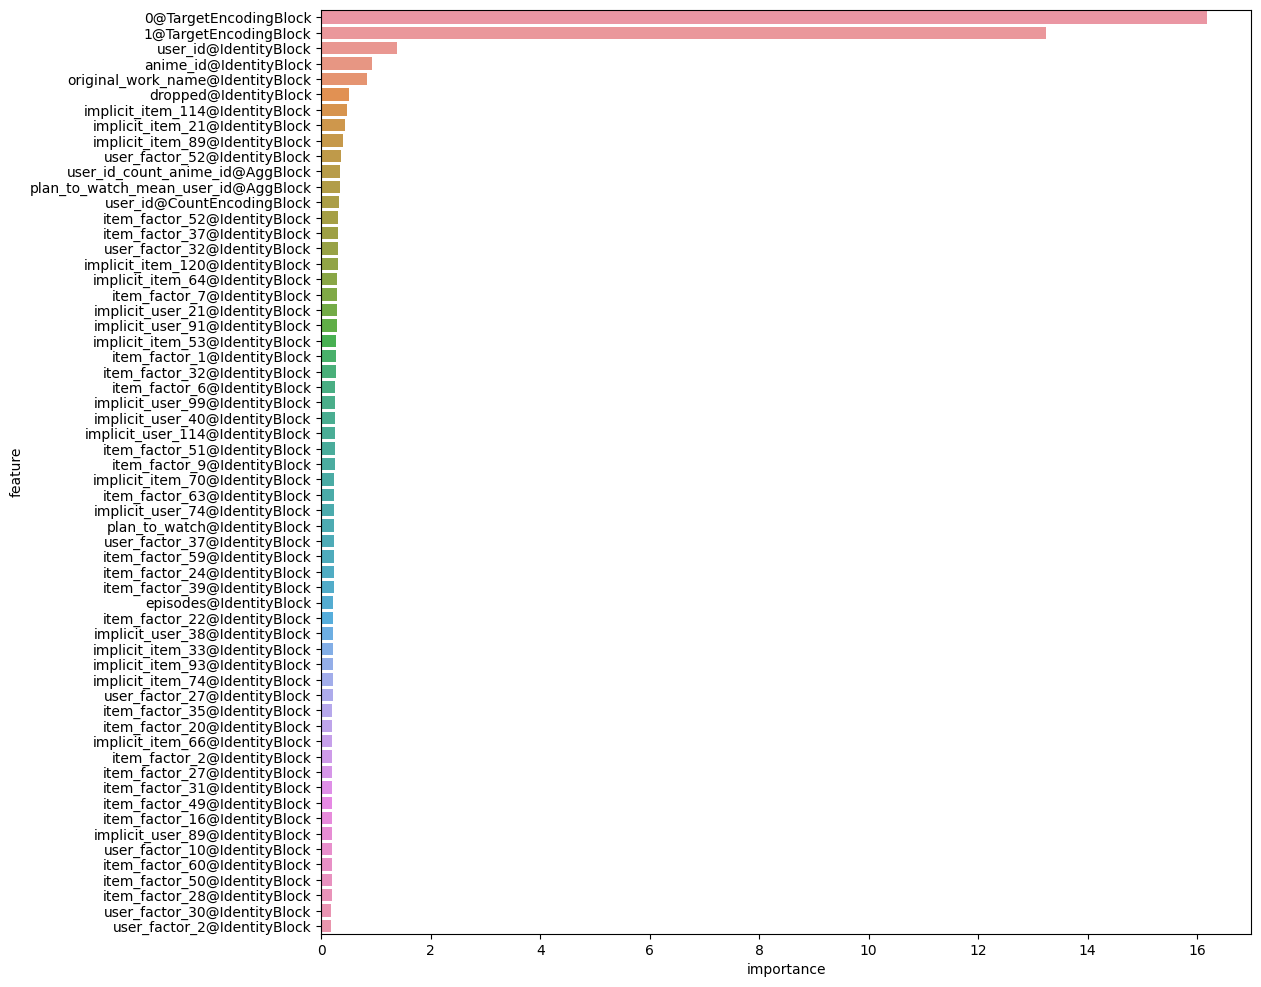

In [152]:
importance_df = pd.DataFrame()
for i_fold in range(cfg.n_splits):
    model = pickle.load(open(cfg.exp_model_path / f"seen_model_fold{i_fold}.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_names_
    _df["importance"] = model.feature_importances_
    _df["fold"] = i_fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False).head(60))

<Axes: xlabel='importance', ylabel='feature'>

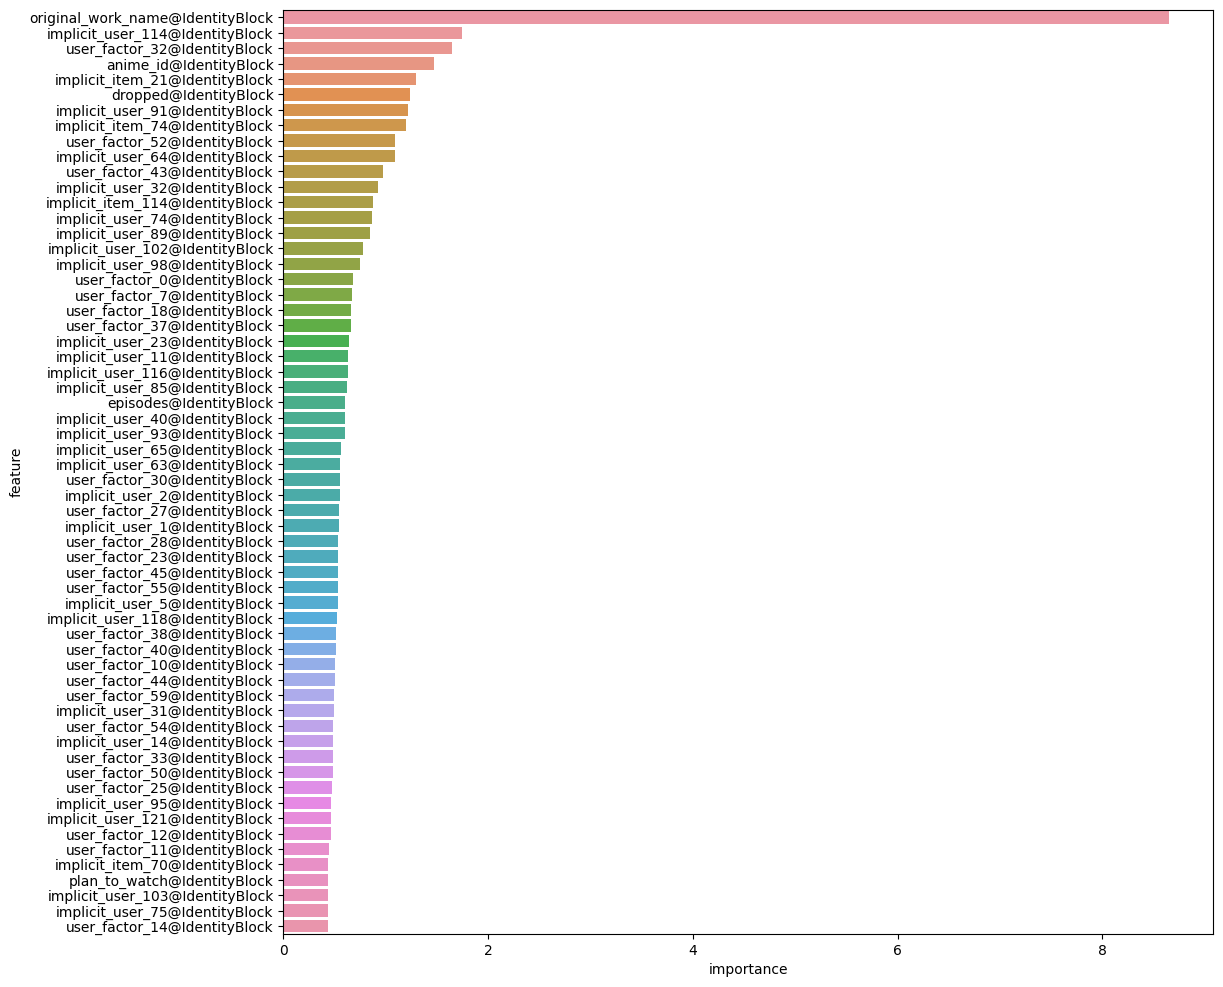

In [153]:
importance_df = pd.DataFrame()
for i_fold in range(cfg.n_splits):
    model = pickle.load(open(cfg.exp_model_path / f"unseen_model_fold{i_fold}.pkl", "rb"))
    _df = pd.DataFrame()
    _df["feature"] = model.feature_names_
    _df["importance"] = model.feature_importances_
    _df["fold"] = i_fold
    importance_df = pd.concat([importance_df, _df], axis=0)

importance_df.groupby("feature").agg({"importance": ["mean", "std"]}).sort_values(("importance", "mean"), ascending=False)

fig, ax = plt.subplots(figsize=(12, 12))
sns.barplot(x="importance", y="feature", data=importance_df.groupby("feature").agg({"importance": "mean"}).reset_index().sort_values("importance", ascending=False).head(60))

Text(0.5, 1.0, 'All users')

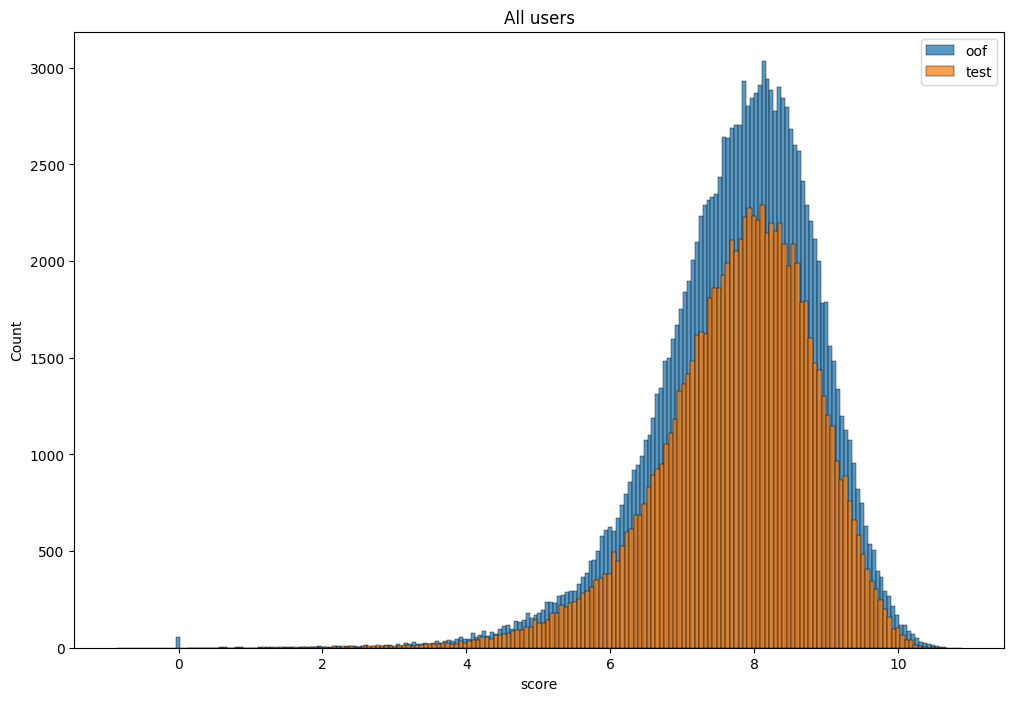

In [154]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=seen_oof, label="oof")
# sns.histplot(data=train_df["score"], label="target")
sns.histplot(data=test_df.iloc[seen_test_idx]["score"], label="test")
ax.legend()
ax.set_title("All users")

Text(0.5, 1.0, 'All users')

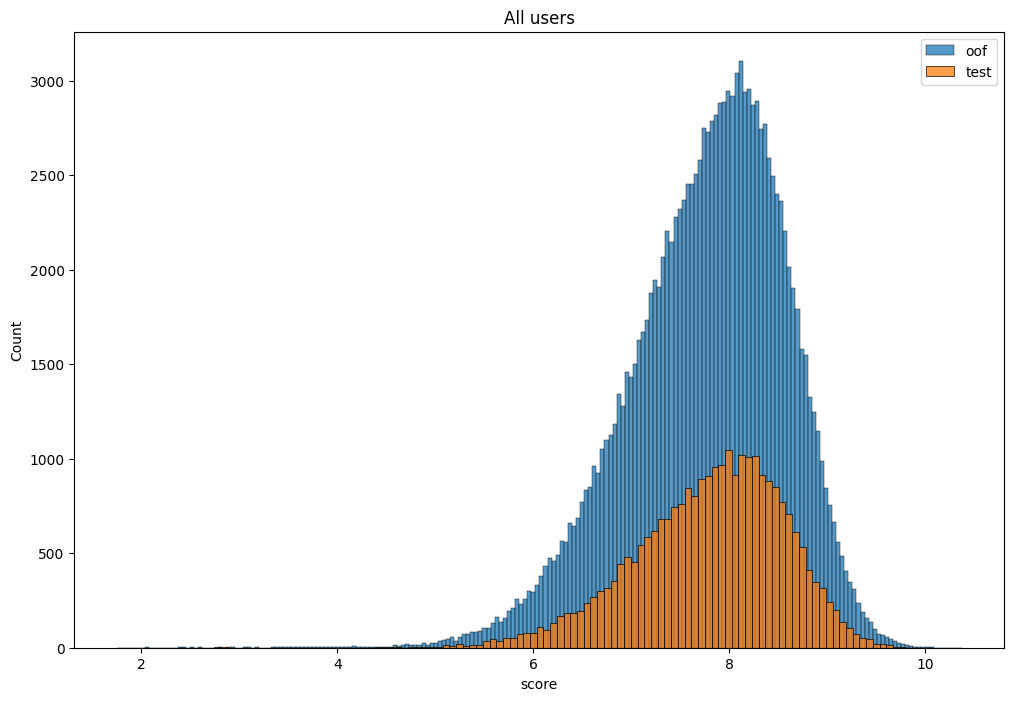

In [155]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.histplot(data=unseen_oof, label="oof")
# sns.histplot(data=train_df["score"], label="target")
sns.histplot(data=test_df.iloc[unseen_test_idx]["score"], label="test")
ax.legend()
ax.set_title("All users")